In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns',100)
import seaborn as sns

#%matplotlib notebook

from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import roc_curve

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Conv2D, Flatten, LSTM, Dropout
import tensorflow as tf

Using TensorFlow backend.


The general strategy for classifying if a machine failure is imminent at any given time will be to introduce a target variable 'close_to_fail', which is 1 at times shortly before a machine failure and 0 at all other times. An LSTM will then be trained for classifying samples (each sample consisting of a few consecutive datapoints) of the given sensor data into these 2 categories!

Define a few parameters which are needed later:

In [2]:
time_steps = 60 #how many time steps (minutes) are in 1 sample, should be multiple or divisor of 60
hours_to_breakdown = 24 #how many hours before a failure is consider being 'shortly before the failure'
test_size = 0.2 #size of the test set
validation_size = 0.2 #size of the validation dataset

In [3]:
df_sensor = pd.read_csv('sensor.csv')
df_sensor.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,220301.000000,220301.000000,220301.000000,220301.000000,220299.000000,0.0,220289.000000,220274.000000,220274.000000,220304.000000,220304.000000,220304.000000,220279.000000,220304.000000,220304.000000,220284.000000,220300.000000,220304.000000,220304.000000,220248.000000,220059.000000,220304.00000,220252.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,41.470339,41.918319,29.136975,7.078858,376.860041,NaN,416.472892,421.127517,2.303785,590.829775,360.805165,796.225942,459.792815,922.609264,556.235397,649.144799,786.411781,501.506589,851.690339,576.195305,614.596442,863.32310,804.283915,486.405980,234.971776,427.129817,593.033876,60.787360,49.655946,36.610444,68.844530,35.365126,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,12.093519,13.056425,10.113935,6.901755,113.206382,NaN,126.072642,129.156175,0.765883,199.345820,101.974118,226.679317,154.528337,291.835280,182.297979,220.865166,246.663608,169.823173,313.074032,225.764091,195.726872,283.54476,260.602361,150.751836,88.376065,141.772519,289.385511,37.604883,10.540397,15.613723,21.371139,7.898665,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,0.000000,0.000000,0.000000,0.000000,32.409550,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.95833,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,24.479166,19.270830,23.437500,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,40.705260,38.856420,28.686810,1.538516,418.103250,NaN,459.453400,454.138825,2.447542,662.768975,398.021500,875.464400,478.962600,950.922400,601.151050,693.957800,790.489575,448.297950,782.682625,518.947225,627.777800,839.06240,760.607475,489.761075,172.486300,353.176625,288.547575,28.799220,45.572910,32.552080,57.812500,32.552080,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,44.291340,45.363140,32.515830,2.929809,420.106200,NaN,462.856100,462.020250,2.533704,665.672400,399.367000,879.697600,531.855900,981.925000,625.873500,740.203500,861.869600,494.468450,967.279850,564.872500,668.981400,917.70830,878.850750,512.271750,226.356050,473.349350,709.668050,64.295485,49.479160,35.416660,66.406250,34.895832,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160

As seen in the desctiption of the dataframe above, sensor 15 has no values, sensor 50 has many missing values. I drop them:

In [4]:
df_sensor = df_sensor.drop(columns='sensor_15')
df_sensor = df_sensor.drop(columns='sensor_50')
print(df_sensor.columns)

Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_51', 'machine_status'],
      dtype='object')


Renaming the 'machine_status' and the unnamed column containing the time index and check the results of these operations: 

In [5]:
df_sensor['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [6]:
df_sensor = df_sensor.replace(to_replace = {'NORMAL':0, 'BROKEN':1, 'RECOVERING':2})

In [7]:
df_sensor = df_sensor.rename(columns = {'Unnamed: 0': 'time_index'})
df_sensor.columns

Index(['time_index', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_51', 'machine_status'],
      dtype='object')

Convert the 'timestamp' column to the pandas datetime format:

In [8]:
df_sensor['timestamp'] = pd.to_datetime(df_sensor['timestamp'], infer_datetime_format = True)
df_sensor[['timestamp']].dtypes

timestamp    datetime64[ns]
dtype: object

Plotting the timestamp vs the time_index column: Looks like the events are equally spaced in time between beginning of April and End of August 2018:

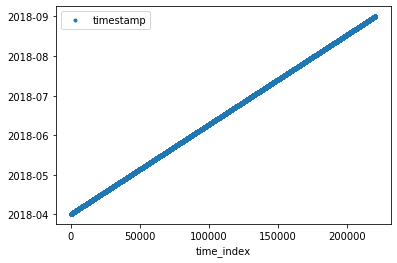

In [9]:
df_sensor.plot('time_index','timestamp',style = '.')

The events are really equally distanced in time with 1 minute spacing:

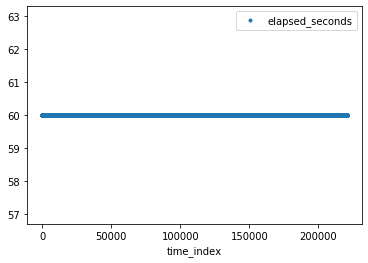

In [10]:
df_sensor['elapsed_seconds'] = ((df_sensor['timestamp'] - df_sensor['timestamp'].shift()).dt.total_seconds().fillna(value=60))
df_sensor.plot('time_index','elapsed_seconds',style = '.')

There are seven events of machine failure, followed by recovering periods with differing length: 

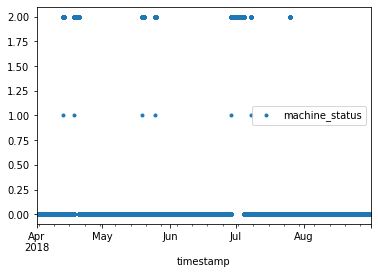

In [11]:
df_sensor.plot('timestamp','machine_status',style='.')

Introducing a column marking events for which a machine failure will occur in hours_to_breakdown hours. This paramter was tuned by looking at the time series data of different sensor, which seem to change on the timescale of a day / a few days. This column will later be used as the target variable.

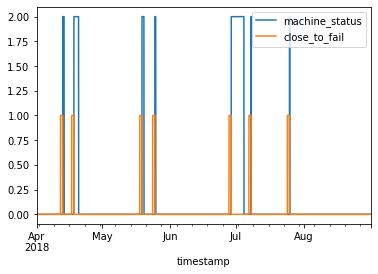

In [12]:
fail_index_list = df_sensor.time_index[df_sensor['machine_status'] == 1].tolist()

def make_fail_index_column(df, fail_index_list, hours_to_breakdown):
    
    df['close_to_fail'] = 0
    for fail_index in fail_index_list:
        start_index = fail_index - hours_to_breakdown * 60
        df.loc[start_index:fail_index, 'close_to_fail'] = 1
    
    return df
    
df_sensor = make_fail_index_column(df_sensor, fail_index_list, hours_to_breakdown)
fix, ax = plt.subplots()
df_sensor.plot('timestamp','machine_status', ax = ax)
df_sensor.plot('timestamp','close_to_fail', ax = ax)
plt.show()

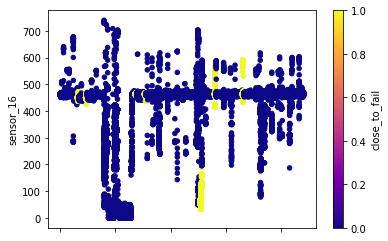

In [13]:
df_sensor.plot.scatter('time_index', 'sensor_16', c = 'close_to_fail', cmap = 'plasma')

Events with machine_status broken and recovering will not be used for the classification:

In [14]:
df_sensor = df_sensor.loc[ df_sensor['machine_status'] == 0 ]

In [15]:
df_sensor.describe()

,time_index,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,elapsed_seconds,close_to_fail
count,205836.000000,205822.000000,205497.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205815.000000,205805.000000,205790.000000,205790.000000,205820.000000,205820.000000,205820.000000,205795.000000,205820.000000,205820.000000,205800.000000,205816.000000,205820.000000,205820.000000,205764.000000,205575.000000,205820.000000,205768.000000,205820.000000,205820.000000,205820.000000,205820.000000,205820.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,193452.000000,205836.0,2.058360e+05,205836.000000
mean,111279.032118,2.420476,48.180116,51.636949,44.167060,625.673284,75.389764,13.865073,16.165959,15.478129,15.086662,44.268913,44.769889,31.172339,7.572760,374.106733,413.491214,418.570430,2.290436,586.169460,358.451047,791.148867,456.537252,915.207197,551.457556,644.565688,781.439069,500.039543,834.805447,573.007596,608.653372,851.400569,794.855086,482.223429,235.898688,423.701112,594.512709,60.108866,50.664023,36.711074,70.970998,35.581951,35.433287,44.226583,43.380628,43.784593,48.858626,45.047102,158.886268,58.569956,200.720874,0.0,6.000000e+01,0.048971
std,64400.871711,0.242472,2.240173,1.878299,1.668260,50.822684,9.381707,0.864943,0.600457,0.588606,0.572969,6.048122,7.602401,6.802214,6.873285,116.480334,129.733253,133.048175,0.788144,205.059043,104.887761,233.151735,158.885019,299.415820,186.912857,227.025417,253.186763,172.686019,315.731104,230.322912,200.362019,285.366194,261.595990,154.122437,90.193503,143.801919,293.535541,37.881774,7.664510,10.593935,17.896944,5.218267,6.249140,7.487652,11.174819,12.439904,14.677281,9.996973,78.707598,17.939210,62.304341,0.0,7.105427e-15,0.215808
min,0.000000,0.000000,0.000000,37.413190,33.289930,2.798032,0.000000,0.014468,0.028935,0.028935,0.007234,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.958330,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,27.604166,21.354166,30.468750,22.395830,23.958330,28.906250,27.199070,27.199070,29.513889,28.935180,28.935180,29.224537,30.960648,0.0,6.000000e+01,0.000000
25%,55514.750000,2.444734,46.701390,50.651040,43.142361,628.240700,70.501157,13.382520,15.950520,15.183740,15.053530,41.513927,40.311177,29.861152,1.742123,418.203750,459.539000,454.129550,2.447299,662.846075,398.056700,875.547050,479.320300,950.940125,600.585900,694.582675,794.045825,446.336325,773.104650,520.656700,625.463000,830.729100,746.356725,488.349700,172.180600,349.746400,264.171375,27.499360,46.093750,32.812500,59.114580,32.812500,33.072910,40.364580,37.615742,37.615740,41.087960,39.641200,92.592590,48.900460,181.423600,0.0,6.000000e+01,0.000000
50%,108892.500000,2.456539,48.263890,51.736111,44.357635,633.333374,75.648000,13.679110,16.167530,15.494790,15.082470,44.693390,45.985220,32.835200,3.806526,420.098500,462.829100,462.016700,2.533631,665.688650,399.372800,879.706600,531.736100,981.545250,625.706550,740.243250,854.181400,493.295700,940.186300,565.699550,666.666600,911.458300,876.647400,511.287800,227.054900,471.321000,771.918100,63.508845,49.739580,35.677080,67.447910,35.156250,35.156250,43.229160,40.798611,40.509260,45.138890,43.11342

The following code realized a randomized stratified split of the data into train and test data. The split is made preserving the distribution of the target variable ('close_to_fail') in train and test data. Furthermore batches of data consisting of 'time_steps' consecutive datapoints are kept together, because they are 1 sample for the input for the LSTM, which is later used for classification:

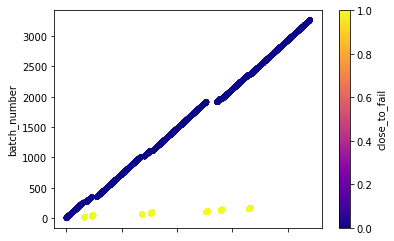

In [16]:
def assign_batch_number(df, time_steps):
    
    df['row_number'] = np.arange(len(df))
    df.loc[:,'batch_number'] = df['row_number']/time_steps
    df['batch_number'] = df['batch_number'].astype(int)
    
    return df


df_sensor = df_sensor.sort_values(by='time_index')
df_0 = df_sensor.loc[ df_sensor['close_to_fail'] == 0 ].copy()
df_1 = df_sensor.loc[ df_sensor['close_to_fail'] == 1 ].copy()

df_0 = assign_batch_number(df_0, time_steps)
df_1 = assign_batch_number(df_1, time_steps)

#print(df_0.shape)
#print(df_1.shape)

batch_list_0 = df_0['batch_number'].unique()
batch_list_1 = df_1['batch_number'].unique()

np.random.shuffle(batch_list_0)
np.random.shuffle(batch_list_1)

test_batch_size_0 = int(test_size * len(batch_list_0))
test_batch_size_1 = int(test_size * len(batch_list_1))

test_batch_list_0 = batch_list_0[:test_batch_size_0]
train_batch_list_0 = batch_list_0[test_batch_size_0:]

test_batch_list_1 = batch_list_1[:test_batch_size_1]
train_batch_list_1 = batch_list_1[test_batch_size_1:]


df_train_0 = df_0.loc[ df_0['batch_number'].isin(train_batch_list_0) ]
df_test_0 = df_0.loc[ df_0['batch_number'].isin(test_batch_list_0) ]

df_train_1 = df_1.loc[ df_1['batch_number'].isin(train_batch_list_1) ]
df_test_1 = df_1.loc[ df_1['batch_number'].isin(test_batch_list_1) ]

df_train = pd.concat([df_train_0,df_train_1])
df_test = pd.concat([df_test_0,df_test_1])

df_train = df_train.sort_values(by='time_index')
df_test = df_test.sort_values(by='time_index')

df_sensor = pd.concat([df_test,df_train])

#print(df_train.shape)
#print(df_test.shape)
#print('shape out:',df_sensor.shape)
#print(df_sensor.columns)

df_test.plot.scatter('time_index','batch_number',c='close_to_fail',cmap='plasma')

The few missing values are filled with the median value of the respective column. For filling in gaps in the test data, only information from the training data is used:

In [17]:
column_list = df_sensor.columns.values
sensor_list = [s for s in column_list if 'sensor' in s]
for column_name in sensor_list:
    median = df_train[column_name].median()
    df_train[column_name] = df_train[column_name].fillna(value=median)
    df_test[column_name] = df_test[column_name].fillna(value=median)


In [18]:
df_sensor.describe()

,time_index,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,elapsed_seconds,close_to_fail,row_number,batch_number
count,205836.000000,205822.000000,205497.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205822.000000,205815.000000,205805.000000,205790.000000,205790.000000,205820.000000,205820.000000,205820.000000,205795.000000,205820.000000,205820.000000,205800.000000,205816.000000,205820.000000,205820.000000,205764.000000,205575.000000,205820.000000,205768.000000,205820.000000,205820.000000,205820.000000,205820.000000,205820.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,205814.000000,193452.000000,205836.0,2.058360e+05,205836.000000,205836.000000,205836.000000
mean,111279.032118,2.420476,48.180116,51.636949,44.167060,625.673284,75.389764,13.865073,16.165959,15.478129,15.086662,44.268913,44.769889,31.172339,7.572760,374.106733,413.491214,418.570430,2.290436,586.169460,358.451047,791.148867,456.537252,915.207197,551.457556,644.565688,781.439069,500.039543,834.805447,573.007596,608.653372,851.400569,794.855086,482.223429,235.898688,423.701112,594.512709,60.108866,50.664023,36.711074,70.970998,35.581951,35.433287,44.226583,43.380628,43.784593,48.858626,45.047102,158.886268,58.569956,200.720874,0.0,6.000000e+01,0.048971,93331.127937,1555.027167
std,64400.871711,0.242472,2.240173,1.878299,1.668260,50.822684,9.381707,0.864943,0.600457,0.588606,0.572969,6.048122,7.602401,6.802214,6.873285,116.480334,129.733253,133.048175,0.788144,205.059043,104.887761,233.151735,158.885019,299.415820,186.912857,227.025417,253.186763,172.686019,315.731104,230.322912,200.362019,285.366194,261.595990,154.122437,90.193503,143.801919,293.535541,37.881774,7.664510,10.593935,17.896944,5.218267,6.249140,7.487652,11.174819,12.439904,14.677281,9.996973,78.707598,17.939210,62.304341,0.0,1.566140e-17,0.215808,58641.479221,977.358005
min,0.000000,0.000000,0.000000,37.413190,33.289930,2.798032,0.000000,0.014468,0.028935,0.028935,0.007234,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.958330,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,27.604166,21.354166,30.468750,22.395830,23.958330,28.906250,27.199070,27.199070,29.513889,28.935180,28.935180,29.224537,30.960648,0.0,6.000000e+01,0.000000,0.000000,0.000000
25%,55514.750000,2.444734,46.701390,50.651040,43.142361,628.240700,70.501157,13.382520,15.950520,15.183740,15.053530,41.513927,40.311177,29.861152,1.742123,418.203750,459.539000,454.129550,2.447299,662.846075,398.056700,875.547050,479.320300,950.940125,600.585900,694.582675,794.045825,446.336325,773.104650,520.656700,625.463000,830.729100,746.356725,488.349700,172.180600,349.746400,264.171375,27.499360,46.093750,32.812500,59.114580,32.812500,33.072910,40.364580,37.615742,37.615740,41.087960,39.641200,92.592590,48.900460,181.423600,0.0,6.000000e+01,0.000000,41378.750000,689.000000
50%,108892.500000,2.456539,48.263890,51.736111,44.357635,633.333374,75.648000,13.679110,16.167530,15.494790,15.082470,44.693390,45.985220,32.835200,3.806526,420.098500,462.829100,462.016700,2.533631,665.688650,399.372800,879.706600,531.736100,981.545250,625.706550,740.243250,854.181400,493.295700,940.186300,565.699550,666.666600,911.458300,876.647400,511.28780

Standardizing the sensor columns. For scaling the test data, only information from the training data is used:

In [19]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_train[sensor_list])
df_train[sensor_list] = scaler.transform(df_train[sensor_list])
df_test[sensor_list] = scaler.transform(df_test[sensor_list])

df_sensor = pd.concat([df_test,df_train])
df_sensor = df_sensor.sort_values(by='time_index')
print(df_sensor.shape)

(205836, 57)


Looking for correlations of the sensor data with the 'close_to_fail' target variable. Sensors 1, 28 and 36 seem to show correlations with the target. This could be used for feature selection:

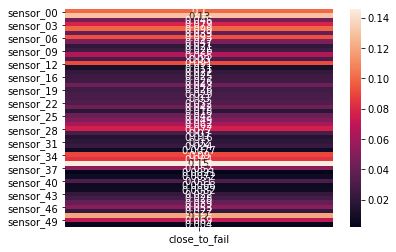

In [20]:
df_corr = df_train[sensor_list+['close_to_fail']].corr().abs() 
df_corr = df_corr.drop(index='close_to_fail')
sns.heatmap(df_corr[['close_to_fail']],annot=True)
plt.show()

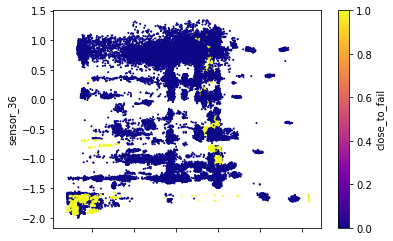

In [21]:
df_train.plot.scatter('sensor_28','sensor_36',c='close_to_fail',cmap='plasma', s=1)

Looking for correlations within the features. Again, this information could be used for feature selection by getting rid of highly correlated features.

In [22]:
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['sensor_04', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']


Shaping the features for training and test data into 3d numpy array of the form (samples, time steps, features) and the input labels into the form (samples, 1). Also oversampling the target datapoint of class 1, for which a machine failure is imminent, to get a balanced train and test sample:

In [23]:
def shape_input(df, time_steps):
    
    column_list = df_train.columns.values
    sensor_list = [s for s in column_list if 'sensor' in s]
    
    df_f = df.copy()
    
    
    df_0 = df_f.loc[ df_f['close_to_fail'] == 0 ]
    df_1 = df_f.loc[ df_f['close_to_fail'] == 1 ]
       
    df_0 = df_0[sensor_list]
    df_1 = df_1[sensor_list]
    
    np_0 = df_0.to_numpy()
    np_1 = df_1.to_numpy()
    
    class_imbalance = int(np_0.shape[0]/np_1.shape[0])
    np_1_orig = np_1.copy()
    
    for i in range(class_imbalance):
        np_1 = np.vstack((np_1, np_1_orig))
    
    samples_0 = int(np_0.shape[0]/time_steps)
    samples_1 = int(np_1.shape[0]/time_steps)
    
    print('samples 0:', samples_0)
    print('samples 1:', samples_1)
    
    n_features = len(sensor_list)
    
    cutoff_0 = time_steps * samples_0
    np_0 = np_0[:cutoff_0,:]
    
    input_features = np.vstack((np_0, np_1))
    input_features = input_features.reshape(samples_0+samples_1, time_steps, n_features)
    
    input_labels = np.asarray( samples_0 * [0] + samples_1 * [1] )
    input_labels = input_labels.reshape(samples_0 + samples_1,1)

    
    return input_features, input_labels

print('train df:')
train_features,train_labels = shape_input(df_train,time_steps)
print('test df:')
test_features,test_labels = shape_input(df_test,time_steps)

print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

train df:
samples 0: 2611
samples 1: 2700
test df:
samples 0: 651
samples 1: 660
(5311, 60, 50)
(5311, 1)
(1311, 60, 50)
(1311, 1)


Defining the neural network. An LSTM is used, due to its innate capabilities for classifying time series data. Batches of time_steps consecutive datapoints are the input. The output is a single unit with sigmoid activation, which is standard for binary classification. Same goes for binary crossentropy as loss function. The model is trained on the training data. Early stopping is implemented to avoid overfitting. 

In [24]:
model = Sequential()

sequence_length = train_features.shape[1]
nb_features = train_features.shape[2]

model.add( LSTM(input_shape=(sequence_length, nb_features),units=50) ) 
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(thresholds=0.5)])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
print(model.summary())
training = model.fit(train_features, train_labels, validation_split = 0.33, epochs=50, batch_size=100) #
eval_result = model.evaluate(test_features, test_labels)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 20,251
Trainable params: 20,251
Non-trainable params: 0
_________________________________________________________________
None
Train on 3558 samples, validate on 1753 samples
Epoch 1/50
3558/3558 [==============================] - 2s 546us/step - loss: 0.4919 - recall: 0.5280 - val_loss: 0.6123 - val_recall: 0.6174
Epoch 2/50
3558/3558 [==============================] - 2s 454us/step - loss: 0.2267 - recall: 0.6745 - val_loss: 0.2904 - val_recall: 0.7575
Epoch 3/50
3558/3558 [==============================] - 2s 451us/step - loss: 0.1418 - recall: 0.8049 - val_loss: 0.1981 - val_recall: 0.8380
Epoch 4/50
3558/3558 [===========

In [25]:
print('The true positive rate (recall) on the test set is:', eval_result[1])

The true positive rate (recall) on the test set is: 0.9867417812347412


Evaluate the validation and the training loss, where a minimum of the validation loss represents an optimum:

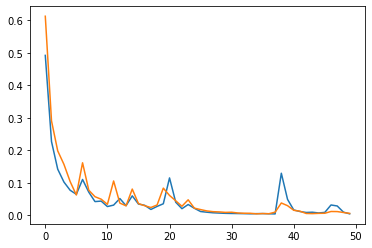

In [26]:
history = training.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.show()

Plotting the ROC curve. The optimal threshold value for the binary classification should be evaluated together with domain experts:

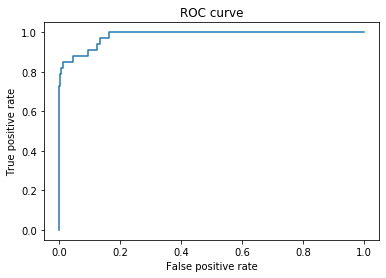

In [27]:
test_labels_predict = model.predict(test_features).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, test_labels_predict)
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

Further tweaking of the workflow could include: <br />
    adjusting hyperparamters: hours_to_breakdown, time_steps<br />
    adjusting hyperparamters of the neural network: number of units/layers, loss function, learning rate, activation<br />
    adjusting methods against overfitting (better early stopping, introducing checkpoints)<br />
    try other data augmentation techniques (eg SMOTE)